In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR_long_only.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\traitlets\con

In [3]:
PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR_long_only\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR_long_only\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")


fixed_shrk_name = 'cov1Para'
opt_shrk_name = 'cov1Para'
with open(rf"{base_folder_path}\ONE_YR_long_only\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR_long_only\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

with open(rf"{base_folder_path}\ONE_YR_long_only\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_rawres_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    rawres_fixed_shrk_data = pickle.load(f)

# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

cov1para_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]

In [4]:
all_res = rawres_fixed_shrk_data.rolling(window=21, min_periods=1).std().bfill()*np.sqrt(252) * 100
all_factors = fixed_shrk_data.iloc[:, 2:].columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)

"""
Y = Y[list(range(0, all_res.shape[0], 21))]
Y = np.repeat(Y, 21)
"""

#Y = a

opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))

# old: Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
Y = np.array(re_hf.map_factors_to_preds(Y, all_factors))

opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values



In [5]:
opt_new = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_new = np.insert(arr=opt_new, obj=0, values=np.repeat(0.15, 21))
opt_new = opt_new[list(range(0, opt_new.shape[0], 21))]
opt_new = np.repeat(opt_new, 21)

ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt_new = pd.Series(opt_new).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

In [6]:
params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, opt_new, rolling_opt_new, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100]  
}

X = re_hf.load_additional_train_data(**params)

In [7]:
Y = optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100*0.5 + Y*0.5

In [23]:
# XGB model
from xgboost import XGBRegressor

xgb_params  = dict(
            max_depth=6,
            colsample_bytree=0.5,
            subsample=0.8,
            n_estimators=3000,
            learning_rate=0.01,
            min_child_weight=40,
            gamma=1,
            eta=0.0,
            reg_lambda=0.1,
            reg_alpha=0.1,
            objective="reg:pseudohubererror"
        )

def general_single_output_XGBRegression_Lagged(X, Y, len_train, cur_params, single_train=False, expanding=False, train_size=None):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else: # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = XGBRegressor(random_state=123, **cur_params, verbose=-1)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = XGBRegressor(random_state=123, **cur_params, verbose=-1)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)
            '''
            if preds < 0:
                preds = 0
            if preds > 30:
                preds = 30
            else:
                pass
            '''
            #preds = int(np.round(preds, 0))

            print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)


In [24]:
## test base
xgb_params  = dict(
            max_depth=6,
            colsample_bytree=0.5,
            subsample=0.8,
            n_estimators=3000,
            learning_rate=0.01,
            min_child_weight=40,
            gamma=1,
            eta=0.0,
            reg_lambda=0.1,
            reg_alpha=0.1,
            objective="reg:pseudohubererror"
        )



c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning: [16:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


fitted model in iteration 0 out of 253
fitted model in iteration 1 out of 253
fitted model in iteration 2 out of 253
fitted model in iteration 3 out of 253
fitted model in iteration 4 out of 253
fitted model in iteration 5 out of 253
fitted model in iteration 6 out of 253
fitted model in iteration 7 out of 253
fitted model in iteration 8 out of 253
fitted model in iteration 9 out of 253
fitted model in iteration 10 out of 253
fitted model in iteration 11 out of 253
fitted model in iteration 12 out of 253
fitted model in iteration 13 out of 253
fitted model in iteration 14 out of 253
fitted model in iteration 15 out of 253
fitted model in iteration 16 out of 253
fitted model in iteration 17 out of 253
fitted model in iteration 18 out of 253
fitted model in iteration 19 out of 253
fitted model in iteration 20 out of 253
fitted model in iteration 21 out of 253
fitted model in iteration 22 out of 253
fitted model in iteration 23 out of 253
fitted model in iteration 24 out of 253
fitted mod

In [50]:
## test base
xgb_params  = dict(
            max_depth=6,
            colsample_bytree=0.5,
            subsample=0.8,
            n_estimators=3000,
            learning_rate=0.01,
            min_child_weight=40,
            gamma=1,
            eta=0.0,
            reg_lambda=0.1,
            reg_alpha=0.1,
            objective="reg:pseudohubererror"
        )

res = general_single_output_XGBRegression_Lagged(X=X, Y=Y/100, cur_params=xgb_params, len_train=5040)


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 0 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 1 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 2 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 3 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 4 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 5 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 6 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 7 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 8 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 9 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 10 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 11 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 12 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 13 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 14 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 15 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 16 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 17 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 18 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 19 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 20 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 21 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 22 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 23 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 24 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 25 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 26 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:02:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 27 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 28 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 29 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 30 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 31 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 32 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 33 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 34 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 35 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 36 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 37 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 38 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 39 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 40 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 41 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 42 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 43 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 44 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 45 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 46 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 47 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 48 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 49 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 50 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 51 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 52 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 53 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 54 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 55 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 56 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 57 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 58 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 59 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 60 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 61 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 62 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 63 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 64 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 65 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:03:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 66 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 67 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 68 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 69 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 70 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 71 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 72 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 73 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 74 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 75 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 76 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 77 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 78 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 79 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 80 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 81 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 82 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 83 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 84 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 85 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 86 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 87 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 88 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 89 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 90 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 91 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 92 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 93 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 94 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 95 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 96 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 97 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 98 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 99 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 100 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 101 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 102 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 103 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 104 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 105 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 106 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 107 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 108 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 109 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 110 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 111 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 112 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 113 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 114 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 115 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 116 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 117 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 118 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 119 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 120 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 121 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 122 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 123 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 124 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 125 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 126 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 127 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 128 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 129 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 130 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 131 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 132 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 133 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 134 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 135 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 136 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 137 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 138 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 139 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 140 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 141 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 142 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 143 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:05:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 144 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 145 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 146 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 147 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 148 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 149 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 150 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 151 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 152 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 153 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 154 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 155 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 156 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 157 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 158 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 159 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 160 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 161 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 162 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 163 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 164 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 165 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 166 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 167 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 168 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 169 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 170 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 171 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 172 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 173 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 174 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 175 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 176 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 177 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 178 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 179 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 180 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 181 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 182 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 183 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 184 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 185 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 186 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 187 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 188 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 189 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 190 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 191 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 192 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 193 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 194 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 195 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 196 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 197 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 198 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 199 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 200 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 201 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 202 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 203 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 204 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 205 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 206 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 207 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 208 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 209 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 210 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 211 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 212 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 213 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 214 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 215 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 216 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 217 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 218 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 219 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 220 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 221 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 222 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 223 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 224 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 225 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 226 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 227 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 228 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 229 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 230 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 231 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 232 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 233 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 234 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 235 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 236 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 237 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 238 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 239 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 240 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 241 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 242 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 243 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 244 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 245 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 246 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 247 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 248 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 249 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 250 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 251 out of 253


c:\Users\dkostovic\.conda\envs\FTSE_data_analysis_v2\lib\site-packages\xgboost\core.py:158: UserWarning:

[20:08:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.




fitted model in iteration 252 out of 253


In [51]:
res

array([0.11311388, 0.11311388, 0.11311388, ..., 0.1206414 , 0.1206414 ,
       0.1206414 ], dtype=float32)

In [52]:
res = res.round(2)
res = (res*100).astype(np.int32)

In [49]:
min(Y)

np.float64(1.3439639898770932)

In [48]:
min(res)

np.float32(57.41332)

np.float64(12.165126048226274)

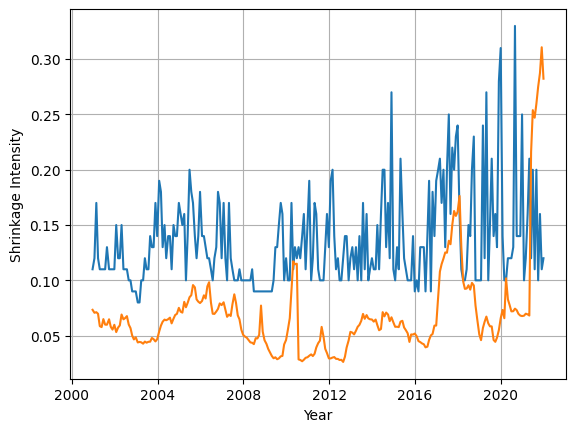

In [53]:
#res = [r if r > 0 else 0 for r in res]
#res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#mapped_res = [ round(i-0.25,2) if i-0.25 >= 0 else i for i in mapped_res ]
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

### Cross Validation

In [171]:
from sklearn.linear_model import ElasticNet
def general_single_output_ElasticNet_Lagged_CrossValidation(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={}):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = ElasticNet(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = ElasticNet(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            preds = np.round(preds, 0)
            model_predictions.append(preds)


def eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train):
    res = [len(intensity_of_intensity_list)-1 if r > len(intensity_of_intensity_list) else r for r in res]
    res = [0 if r < 0 else r for r in res]

    Y_eval = rawres_fixed_shrk_data.iloc[len_cv_train:len_train]

    returns = np.diag(Y_eval.iloc[:, res])
    returns_sd = returns.std() * np.sqrt(252) * 100
    returns_means = returns.mean() * 252 * 100

    return returns_means, returns_sd

In [172]:
len_cv_train = int(len_train*0.8) 

train_x_cv = X[:len_cv_train]
train_y_cv = Y[:len_cv_train]

val_x = X[len_cv_train:len_train]
val_y = Y[len_cv_train:len_train]

In [173]:
from sklearn.model_selection import ParameterGrid
model_params_grid = {
    "alpha": [0.1, 0.5, 1.0, 1.5, 2.0, 5.0],
    "l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
    "max_iter": [2000],
    "tol": [1e-3, 1e-4, 1e-5],
    "fit_intercept": [True, False]
}
model_params_grid = list(ParameterGrid(model_params_grid))
intensity_of_intensity_list = all_res.columns
sds = []
for i, p in enumerate(model_params_grid):
    res = general_single_output_ElasticNet_Lagged_CrossValidation(X=X[:len_train], Y=Y[:len_train], len_train=len_cv_train, model_params=p)
    AV, SD = eval_model_outputs_cross_val(res, intensity_of_intensity_list, len_cv_train, len_train)
    sds.append(SD.round(3))
    if i%10 == 0:
        print(f"fitted model {i} / {len(model_params_grid)}")

fitted model 0 / 180
fitted model 10 / 180
fitted model 20 / 180
fitted model 30 / 180
fitted model 40 / 180
fitted model 50 / 180
fitted model 60 / 180
fitted model 70 / 180
fitted model 80 / 180
fitted model 90 / 180
fitted model 100 / 180
fitted model 110 / 180
fitted model 120 / 180
fitted model 130 / 180
fitted model 140 / 180
fitted model 150 / 180
fitted model 160 / 180
fitted model 170 / 180


#### Evaluate best model on OOS data

np.float64(13.827603085903764)

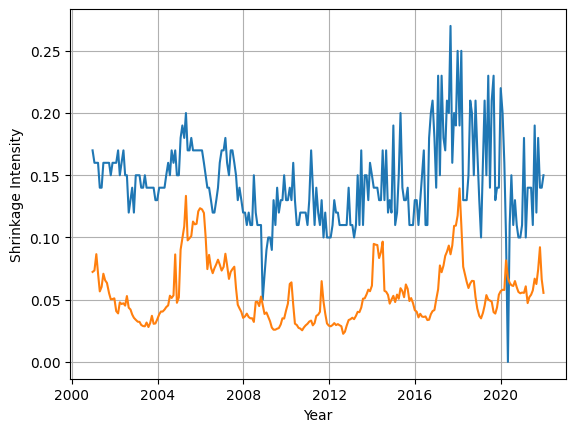

In [174]:
np.argmin(sds)
p_best = model_params_grid[np.argmin(sds)]
res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=len_train, model_params=p_best)
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#mapped_res = [ round(i-0.25,2) if i-0.25 >= 0 else i for i in mapped_res ]
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

In [175]:
print("OOS L_RL RESULTS:")

sd = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100
av = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).mean()*252*100

print("sd: ", sd)
print("ir: ", ir)

OOS L_RL RESULTS:
sd:  13.827603085903764
ir:  0.7072527996216745


In [176]:
px.line(rawres_fixed_shrk_data.iloc[5040:, :].std() * np.sqrt(252) * 100)

# doesnt make sense

brief lgbm testing


In [177]:
res = re_hf.general_single_output_LGBMRegression_Lagged(X=X, Y=Y, cur_params={"num_leaves":50, "n_estimators": 400, "reg_alpha": 0.5, "reg_lambda": 0.5}, len_train=5040)
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]
mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()
np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

fitted model in iteration 0 out of 253
fitted model in iteration 1 out of 253
fitted model in iteration 2 out of 253
fitted model in iteration 3 out of 253
fitted model in iteration 4 out of 253
fitted model in iteration 5 out of 253
fitted model in iteration 6 out of 253
fitted model in iteration 7 out of 253
fitted model in iteration 8 out of 253
fitted model in iteration 9 out of 253
fitted model in iteration 10 out of 253


In [ ]:
print("LGBM RESULTS")
sd = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100
av = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).mean()*252*100

print("sd: ", sd)
print("ir: ", ir)

LGBM RESULTS
sd:  13.891796084154794
ir:  0.6662113239002518


### Save OOS Results of Best model

In [57]:
OUT_PATH = rf"H:\all\RL_Shrinkage_2024\ONE_YR_long_only\Linear_Shrinkage\results\p{PF_SIZE}"
oos_daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res])
pd.Series(oos_daily_rets).to_csv(f"{OUT_PATH}/OOS_daily_returns.csv")

In [58]:
pd.read_csv(OUT_PATH + "/OOS_daily_returns.csv", index_col=0).values.reshape(-1,)

array([ 0.0185481 , -0.00058492, -0.01487173, ...,  0.00230349,
        0.01701414,  0.01262656])

### For Best Model, 
- create grid with AV and SD with convex combinations of the best OOS fixed intensity 
- create our model with the same mean as best OOS fixed intensity

In [59]:
convex_combo_sd = []
convex_combo_av = []
convex_combo_daily_rets = []

OPT_OOS_FIXED_SHRK_DICT = {
    30: 0.13, 
    50: 0.2, 
    100: 0.23, 
    225: 0.24, 
    500: 0.24
    }

OPT_OOS_FIXED_SHRK = OPT_OOS_FIXED_SHRK_DICT[PF_SIZE]
OUT_PATH = rf"H:\all\RL_Shrinkage_2024\ONE_YR_long_only\Linear_Shrinkage\results\p{PF_SIZE}"

for a in list(range(0,11,1)):
    a = a/10   
    x = (np.round((mapped_res * (1-a) + OPT_OOS_FIXED_SHRK * a), 2))
    daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x])   
    convex_combo_daily_rets.append(daily_rets)                  
    convex_combo_av.append(daily_rets.mean() * 252 * 100)
    convex_combo_sd.append(daily_rets.std()* np.sqrt(252) * 100)

convex_combo_av = pd.DataFrame(convex_combo_av, index=[i/10 for i in range(0,11)], columns=[PF_SIZE]).T
convex_combo_sd = pd.DataFrame(convex_combo_sd, index=[i/10 for i in range(0,11)], columns=[PF_SIZE]).T
convex_combo_daily_rets = pd.DataFrame(convex_combo_daily_rets, index=[i/10 for i in range(0,11)]).T

In [60]:
x = np.round(mapped_res * (OPT_OOS_FIXED_SHRK/np.mean(mapped_res)), 2)
x = [x if x<1 else 1 for x in x]
daily_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x])
convex_combo_av['re-scaled'] = daily_rets.mean() * 252 * 100
convex_combo_sd['re-scaled'] = daily_rets.std()* np.sqrt(252) * 100
convex_combo_daily_rets['re-scaled'] = daily_rets

convex_combo_av.to_csv(OUT_PATH + "/Convex_Combo_AV.csv")
convex_combo_sd.to_csv(OUT_PATH + "/Convex_Combo_SD.csv")
convex_combo_daily_rets.to_csv(OUT_PATH + "/Convex_Combo_DailyReturns.csv")

In [61]:
pd.read_csv(OUT_PATH + "/Convex_Combo_SD.csv", index_col=0)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,re-scaled
500,12.134072,12.146268,12.163574,12.188342,12.204689,12.222545,12.240786,12.261861,12.280674,12.298478,12.319458,12.221261


### save oralce and shrinkage intensities of model 

In [62]:
### get oracle
OOS_Rebdates_indexer = list(range(0, 5313, 21))
oracle_min_idx = all_res.iloc[5040:].iloc[OOS_Rebdates_indexer].idxmin(axis=1).astype(np.float64)
oracle_min_idx_repeated = np.repeat(oracle_min_idx, 21).values
oracle_daily_oos_rets = np.diag(rawres_fixed_shrk_data.iloc[5040:, ].loc[:, oracle_min_idx_repeated])

In [63]:
px.line(rawres_fixed_shrk_data.iloc[5040:, ].std() * np.sqrt(252)  *100)

In [64]:
pd.Series(mapped_res, dtype=np.float64).to_csv(OUT_PATH + f"/oos_linear_model_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_min_idx_repeated).to_csv(OUT_PATH + f"/oos_linear_oracle_intensity_p{PF_SIZE}.csv")
pd.Series(oracle_daily_oos_rets).to_csv(OUT_PATH + f"/oos_linear_oracle_dailyrets_p{PF_SIZE}.csv")

In [65]:
# done